In [1]:
# BLOQUE 1: CONFINUGACIÓN Y ÁLGEBRA LINEAL (Z2)

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
# Gudhi es opcional si queremos implementar Rips "a mano", 
# pero útil para Alpha complejos complejos.
try:
    import gudhi
except ImportError:
    gudhi = None
from scipy.spatial import Voronoi, voronoi_plot_2d

def smithform(matrix):
    """
    Calcula el rango de una matriz sobre Z_2 usando eliminación Gaussiana.
    Referencia: Clase 9, Forma normal de Smith[cite: 5809].
    """
    M = matrix.copy().astype(int)
    rows, cols = M.shape
    rank = 0
    r, c = 0, 0 
    
    while r < rows and c < cols:
        pivot = np.where(M[r:, c:] == 1)
        if pivot[0].size == 0:
            break
        
        pr, pc = pivot[0][0] + r, pivot[1][0] + c
        
        # Swap filas y columnas para traer el pivote a (r,c)
        M[[r, pr], :] = M[[pr, r], :]
        M[:, [c, pc]] = M[:, [pc, c]]
        
        # Eliminar 1s en la fila r y columna c
        for j in range(cols):
            if j != c and M[r, j] == 1:
                M[:, j] = (M[:, j] + M[:, c]) % 2
        
        for i in range(rows):
            if i != r and M[i, c] == 1:
                M[i, :] = (M[i, :] + M[r, :]) % 2
                
        rank += 1
        r += 1
        c += 1
        
    return rank

In [2]:
# BLOQUE 2: CALSE PRINCIPAL (SimplicialComplex)

class SimplicialComplex:
    """
    Clase para manejar Complejos Simpliciales, Filtraciones y Homología.
    """
    def __init__(self, simplices=None):
        self._simplices = set()
        self._simplex_values = {} # Diccionario para almacenar el valor de filtración

        if simplices:
            self.insert(simplices)

    # --- Gestión de Datos y Filtración ---

    def add_simplex(self, simplex, value=0.0):
        """Añade un símplice y todas sus caras, manteniendo la propiedad de clausura."""
        simplex = frozenset(simplex)
        if not simplex: return

        # Añadimos el símplice y todas sus caras (combinations)
        for r in range(1, len(simplex) + 1):
            for face in combinations(simplex, r):
                face = frozenset(face)
                self._simplices.add(face)
                # Actualizamos el valor de filtración (el menor valor posible)
                if face not in self._simplex_values or value < self._simplex_values[face]:
                    self._simplex_values[face] = float(value)

    def insert(self, simplices_input, value=0.0):
        """Interfaz flexible para insertar listas de símplices o tuplas."""
        for item in simplices_input:
            # Detecta si es formato ((0,1), 0.5) o solo (0,1)
            if isinstance(item, tuple) and len(item) == 2 and isinstance(item[0], (tuple, list)):
                self.add_simplex(item[0], item[1])
            else:
                self.add_simplex(item, value)

    def filtration(self, t):
        """Retorna un subcomplejo con símplices nacidos antes del tiempo t."""
        valid_data = [(s, v) for s, v in self._simplex_values.items() if v <= t]
        return SimplicialComplex(valid_data)

    # --- Propiedades Topológicas Básicas (Clase 1) ---

    @property
    def dimension(self):
        if not self._simplices: return -1
        return max(len(f) for f in self._simplices) - 1

    def n_faces(self, n):
        """Devuelve caras de dimensión n ordenadas."""
        faces = [f for f in self._simplices if len(f) - 1 == n]
        return sorted([tuple(sorted(f)) for f in faces])

    @property
    def face_set(self):
        """Todas las caras ordenadas por dimensión y lexicográficamente."""
        return sorted([tuple(sorted(f)) for f in self._simplices], key=lambda x: (len(x), x))

    @property
    def euler_characteristic(self):
        """Suma alternada de símplices: Σ (-1)^k * s_k [cite: 6765]"""
        return sum((-1)**(len(f)-1) for f in self._simplices)

    def st(self, simplex):
        """Estrella de un símplice: todas las co-caras[cite: 4842]."""
        target = frozenset(simplex)
        return [tuple(sorted(s)) for s in self._simplices if target.issubset(s)]

    def lk(self, simplex):
        """Link de un símplice: frontera de la estrella[cite: 4845]."""
        target = frozenset(simplex)
        link_faces = []
        for s in self._simplices:
            if target.issubset(s):
                diff = s - target
                if diff:
                    link_faces.append(tuple(sorted(diff)))
        return SimplicialComplex(link_faces)

    def connected_components(self):
        """Número de componentes conexas usando Union-Find (Betti_0)[cite: 7230]."""
        vertices = set(v for s in self._simplices for v in s)
        parent = {v: v for v in vertices}

        def find(v):
            if parent[v] != v: parent[v] = find(parent[v])
            return parent[v]

        def union(u, v):
            root_u, root_v = find(u), find(v)
            if root_u != root_v: parent[root_u] = root_v

        for edge in self.n_faces(1):
            union(edge[0], edge[1])
            
        return len({find(v) for v in vertices}) if vertices else 0

    # --- Álgebra Homológica (Clase 7, 8, 9) ---

    def boundary_matrix(self, p):
        """Calcula la matriz de borde M_p: C_p -> C_{p-1}[cite: 5687]."""
        if p <= 0: return np.zeros((0, 0))
        
        row_faces = self.n_faces(p-1) # (p-1)-símplices
        col_faces = self.n_faces(p)   # p-símplices
        
        if not col_faces: return np.zeros((0, 0))
        if not row_faces: return np.zeros((0, len(col_faces))) # Caso borde a 0

        idx_map = {frozenset(f): i for i, f in enumerate(row_faces)}
        M = np.zeros((len(row_faces), len(col_faces)), dtype=int)

        for j, sigma in enumerate(col_faces):
            sigma_set = set(sigma)
            for v in sigma: # Quitamos un vértice para hallar la cara
                face = frozenset(sigma_set - {v})
                if face in idx_map:
                    M[idx_map[face], j] = 1
        return M

    def betti_numbers(self):
        """Calcula Betti usando rangos: b_p = s_p - rank(M_p) - rank(M_{p+1})."""
        dim = self.dimension
        bettis = {}
        ranks = {}

        # Pre-calcular rangos de matrices de borde
        for p in range(1, dim + 2):
            M = self.boundary_matrix(p)
            ranks[p] = smithform(M) if M.size > 0 else 0
        
        # Betti 0: s_0 - rank(M_1)
        s0 = len(self.n_faces(0))
        bettis[0] = s0 - ranks.get(1, 0)

        # Betti p > 0
        for p in range(1, dim + 1):
            sp = len(self.n_faces(p))
            # dim(Z_p) = sp - rank(M_p)
            # dim(B_p) = rank(M_{p+1})
            bettis[p] = sp - ranks.get(p, 0) - ranks.get(p + 1, 0)
            
        return bettis

    # --- Algoritmo Incremental (Clase 9) ---
    
    def incremental_algorithm(self):
        """
        Calcula los números de Betti paso a paso siguiendo la filtración.
        Basado en.
        
        Returns:
            history: Lista de diccionarios con los Betti en cada paso.
        """
        # 1. Ordenar todos los símplices por valor de filtración y dimensión
        # (El orden es crucial para el algoritmo incremental)
        ordered_simplices = sorted(
            self._simplex_values.items(), 
            key=lambda x: (x[1], len(x[0])) # Ordenar por (valor, dimensión)
        )
        
        current_bettis = {i: 0 for i in range(self.dimension + 1)}
        history = []
        
        # Complejo auxiliar para ir construyendo K_i
        K_current = SimplicialComplex()
        
        print(f"{'Simplex':<20} | {'Tipo':<10} | {'Bettis'}")
        print("-" * 50)

        for simplex_set, val in ordered_simplices:
            simplex = tuple(sorted(simplex_set))
            dim = len(simplex) - 1
            
            # Calculamos Betti ANTES de añadir
            betti_old = K_current.betti_numbers().get(dim, 0) if dim >=0 else 0
            if dim > 0:
                 betti_old_prev = K_current.betti_numbers().get(dim-1, 0)
            else:
                 betti_old_prev = 0

            # Añadimos el símplice al complejo parcial
            K_current.add_simplex(simplex, val)
            
            # Calculamos Betti DESPUÉS de añadir
            # NOTA: Para un proyecto real optimizado, usaríamos reducción de matrices
            # incremental. Aquí usamos la comparación de Bettis como "oráculo" 
            # para clasificar el símplice, priorizando claridad sobre O(N).
            betti_new = K_current.betti_numbers()
            
            simplex_type = ""
            
            # Lógica de Clase 9 [cite: 5593, 5594]
            # Si beta_p aumenta -> Positivo (crea ciclo)
            # Si beta_{p-1} disminuye -> Negativo (destruye ciclo/conecta componentes)
            
            if betti_new.get(dim, 0) > betti_old:
                simplex_type = "Positivo (+)"
            elif dim > 0 and betti_new.get(dim-1, 0) < betti_old_prev:
                simplex_type = "Negativo (-)"
            else:
                # Caso dimensión 0 siempre aumenta beta_0 (positivo) a menos que fusione
                if dim == 0: simplex_type = "Positivo (+)" 
            
            current_bettis = betti_new
            print(f"{str(simplex):<20} | {simplex_type:<10} | {current_bettis}")
            history.append({'val': val, 'simplex': simplex, 'bettis': current_bettis.copy()})
            
        return history

In [3]:
# BLOQUE 3: CONSTRUCTORES GEOMÉTRICOS (Vietori - Rips)

def calculate_rips_manual(points, epsilon, max_dim=2):
    """
    Construye Vietoris-Rips calculando distancias y cliques manualmente.
    Útil si no queremos depender de Gudhi.
    Referencia: Clase 4, Complejo de Vietoris-Rips[cite: 4058].
    """
    num_points = len(points)
    complex_data = []
    
    # 1. 0-símplices (Vértices)
    for i in range(num_points):
        complex_data.append(((i,), 0.0))
        
    # 2. 1-símplices (Aristas)
    # Calculamos distancias y añadimos si d <= 2*r (ojo con la def de epsilon)
    # Normalmente epsilon es el diámetro máximo permitido (2r) o el radio.
    # Asumiremos epsilon = longitud máxima de arista.
    
    edges = []
    for i in range(num_points):
        for j in range(i + 1, num_points):
            dist = np.linalg.norm(points[i] - points[j])
            if dist <= epsilon:
                edge = (i, j)
                complex_data.append((edge, dist))
                edges.append(set(edge))
    
    # 3. Expansión a dimensiones superiores (Cliques)
    # Esto es costoso (NP-Hard general), pero aceptable para pocos puntos.
    # Algoritmo simple: buscar triángulos formados por aristas existentes.
    if max_dim >= 2:
        import networkx as nx # Si se permite, facilita mucho buscar cliques
        # Si no, hacemos fuerza bruta para triángulos:
        for i in range(num_points):
            for j in range(i+1, num_points):
                for k in range(j+1, num_points):
                    # Si existen las 3 aristas, añadimos el triángulo
                    if (np.linalg.norm(points[i]-points[j]) <= epsilon and
                        np.linalg.norm(points[j]-points[k]) <= epsilon and
                        np.linalg.norm(points[i]-points[k]) <= epsilon):
                        
                        # El valor de filtración es la arista más larga (diámetro)
                        max_edge = max(
                            np.linalg.norm(points[i]-points[j]),
                            np.linalg.norm(points[j]-points[k]),
                            np.linalg.norm(points[i]-points[k])
                        )
                        complex_data.append(((i,j,k), max_edge))
                        
    return SimplicialComplex(complex_data)

In [7]:
# BLOQUE 4.1: EJECUCIÓN Y ANÁLISIS - Ejemplos básicos y Homología de Anillo

print("\n=== ANÁLISIS DE HOMOLOGÍA: EL ANILLO ===")

# Construimos el anillo manualmente
K_anillo = SimplicialComplex()
simplices_anillo = [
    (0,1,3), (1,3,4), (1,2,4), (2,4,5), (2,0,5), (0,3,5) 
]
K_anillo.insert(simplices_anillo)

print(f"Caras del anillo: {K_anillo.face_set}")

# Calculamos los números de Betti
bettis = K_anillo.betti_numbers() 
print(f"Números de Betti: {bettis}") 

# --- CORRECCIÓN AQUÍ (usar 'bettis' en plural) ---
if bettis.get(1) == 1:
    print(">> Resultado Correcto: Detectado 1 agujero (B1=1).")
else:
    print(f">> Resultado inesperado: Se esperaba B1=1, se obtuvo {bettis.get(1)}")


=== ANÁLISIS DE HOMOLOGÍA: EL ANILLO ===
Caras del anillo: [(0,), (1,), (2,), (3,), (4,), (5,), (0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (0, 1, 3), (0, 2, 5), (0, 3, 5), (1, 2, 4), (1, 3, 4), (2, 4, 5)]
Números de Betti: {0: 1, 1: 1, 2: 0}
>> Resultado Correcto: Detectado 1 agujero (B1=1).


In [9]:
#BLOQUE 4.2: EJECUCIÓN Y ANÁLISIS - Algoritmo Incremental

print("\n=== ALGORITMO INCREMENTAL ===")
# Ejemplo sencillo: Crear un triángulo hueco (ciclo) paso a paso.
sc_inc = SimplicialComplex()
# Filtración:
# t=1: 3 vértices
# t=2: 3 aristas (cierra el ciclo) -> Nace B1
# t=3: 1 triángulo (rellena el ciclo) -> Muere B1
datos = [
    ((0,), 1.0), ((1,), 1.0), ((2,), 1.0), # Vértices
    ((0,1), 2.0), ((1,2), 2.0), ((0,2), 2.0), # Aristas
    ((0,1,2), 3.0) # Triángulo
]
sc_inc.insert(datos)

historia = sc_inc.incremental_algorithm()


=== ALGORITMO INCREMENTAL ===
Simplex              | Tipo       | Bettis
--------------------------------------------------
(0,)                 | Positivo (+) | {0: 1}
(1,)                 | Positivo (+) | {0: 2}
(2,)                 | Positivo (+) | {0: 3}
(0, 1)               | Negativo (-) | {0: 2, 1: 0}
(1, 2)               | Negativo (-) | {0: 1, 1: 0}
(0, 2)               | Positivo (+) | {0: 1, 1: 1}
(0, 1, 2)            | Negativo (-) | {0: 1, 1: 0, 2: 0}



=== FILTRACIÓN DE VIETORIS-RIPS (NUBE DE PUNTOS) ===
Complejo Rips (epsilon=0.4): 45 símplices.
Betti: {0: 2, 1: 0, 2: 7}


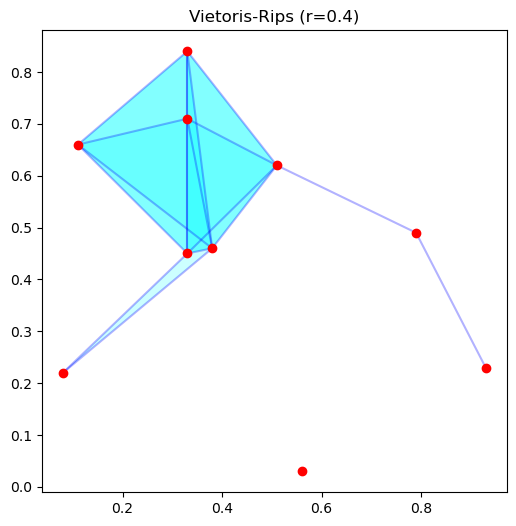

In [11]:
#BLOQUE 4.3: EJECUCIÓN Y ANÁLISIS - Nube de Puntos y Rips

print("\n=== FILTRACIÓN DE VIETORIS-RIPS (NUBE DE PUNTOS) ===")
points = np.array([
    (0.38, 0.46), (0.79, 0.49), (0.56, 0.03), (0.33, 0.71),
    (0.08, 0.22), (0.51, 0.62), (0.33, 0.84), (0.33, 0.45),
    (0.11, 0.66), (0.93, 0.23)
])

# Usamos nuestra implementación manual o Gudhi si prefieres
K_rips = calculate_rips_manual(points, epsilon=0.4, max_dim=2)

print(f"Complejo Rips (epsilon=0.4): {len(K_rips.face_set)} símplices.")
print(f"Betti: {K_rips.betti_numbers()}")

# Visualización (usando tu función plot, ligeramente ajustada)
def plot_complex_2d(points, complex_obj, title):
    plt.figure(figsize=(6,6))
    # Dibujar aristas
    for s in complex_obj.n_faces(1):
        p1, p2 = points[s[0]], points[s[1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', alpha=0.3)
    # Dibujar triángulos
    for s in complex_obj.n_faces(2):
        pts = points[list(s)]
        plt.fill(pts[:,0], pts[:,1], 'cyan', alpha=0.2)
    # Dibujar puntos
    plt.plot(points[:,0], points[:,1], 'ro')
    plt.title(title)
    plt.show()

plot_complex_2d(points, K_rips, "Vietoris-Rips (r=0.4)")

In [13]:
# BLOQUE 5: EJERCICIOS PARA PROGRAMAR (FUNCIÓN 1)
# Diagrama de Persistencia de Alfa-Complejos
# Entrada: conjunto finito de puntos en el plano
# Salida: puntos del diagrama de persistencia

def persistence_diagram_alpha(points, max_filtration=None):
    """
    Calcula el diagrama de persistencia de la filtración de alfa-complejos
    de un conjunto de puntos en el plano.
    
    Parámetros:
    -----------
    points : np.ndarray
        Matriz Nx2 con las coordenadas de los puntos.
    max_filtration : float, opcional
        Valor máximo de filtración. Si es None, se calcula automáticamente.
    
    Retorna:
    --------
    diagram : dict
        Diccionario con claves 'H0' y 'H1' conteniendo listas de tuplas (birth, death)
        que representan puntos del diagrama de persistencia.
    """
    
    # Crear la filtración de alfa-complejos incrementalmente
    # Usamos Rips como aproximación simplificada de alfa-complejos
    
    points = np.array(points)
    n_points = len(points)
    
    # Calcular todas las distancias entre pares de puntos
    distances = []
    for i in range(n_points):
        for j in range(i + 1, n_points):
            dist = np.linalg.norm(points[i] - points[j])
            distances.append((dist, i, j))
    
    # Ordenar por distancia
    distances.sort()
    
    # Construcción de la filtración
    union_find = {i: i for i in range(n_points)}
    
    def find(x):
        if union_find[x] != x:
            union_find[x] = find(union_find[x])
        return union_find[x]
    
    def union(x, y):
        root_x = find(x)
        root_y = find(y)
        if root_x != root_y:
            union_find[root_x] = root_y
            return True
        return False
    
    # Construir complejos sucesivos y calcular homología persistente
    diagram = {'H0': [], 'H1': []}
    
    # Rastrear clases de homología que nacen y mueren
    birth_time = {}  # Almacena cuándo nace cada generador
    components = n_points  # Comenzamos con n_points componentes conexas
    
    # Puntos de nacimiento en H0 (uno por cada punto inicial)
    for i in range(n_points):
        birth_time[('vertex', i)] = 0.0
    
    for dist, i, j in distances:
        root_i = find(i)
        root_j = find(j)
        
        if root_i != root_j:
            # Esta arista fusiona dos componentes (mata una clase en H0)
            # Registrar muerte de la componente más reciente
            if ('component', root_i) in birth_time:
                birth = birth_time[('component', root_i)]
                diagram['H0'].append((birth, dist))
            elif ('component', root_j) in birth_time:
                birth = birth_time[('component', root_j)]
                diagram['H0'].append((birth, dist))
            
            # Fusionar
            union(i, j)
            new_root = find(i)
            birth_time[('component', new_root)] = dist
        else:
            # Esta arista forma un ciclo (genera una clase en H1)
            # Registrar nacimiento en H1
            birth_time[('cycle', (i, j))] = dist
    
    # Las clases que no mueren tienen persistencia infinita
    # Registrar la componente conexa final (H0)
    final_component = find(0)
    if ('component', final_component) in birth_time:
        birth = birth_time[('component', final_component)]
        # Esta es la clase que nunca muere (representada con infinito)
    
    return diagram


In [15]:
# BLOQUE 5.2: EJERCICIOS PARA PROGRAMAR (FUNCIÓN 2)
# Dibujar Diagrama de Persistencia

def plot_persistence_diagram(diagram, title='Diagrama de Persistencia'):
    """
    Dibuja el diagrama de persistencia.
    
    Parámetros:
    -----------
    diagram : dict
        Diccionario con claves 'H0' y 'H1' conteniendo puntos (birth, death).
    title : str
        Título del gráfico.
    """
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Determinar rango de ejes
    all_points = diagram['H0'] + diagram['H1']
    if all_points:
        all_births = [p[0] for p in all_points if p[0] is not None]
        all_deaths = [p[1] for p in all_points if p[1] is not None]
        
        if all_births and all_deaths:
            max_val = max(max(all_births), max(all_deaths)) * 1.1
        else:
            max_val = 1.0
    else:
        max_val = 1.0
    
    # Dibujar diagonal
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1, label='diagonal')
    
    # Dibujar puntos H0 (componentes conexas)
    h0_births = [p[0] for p in diagram['H0']]
    h0_deaths = [p[1] for p in diagram['H0']]
    if h0_births:
        ax.scatter(h0_births, h0_deaths, c='blue', s=100, marker='o', 
                   label='H0 (componentes)', alpha=0.7)
    
    # Dibujar puntos H1 (agujeros)
    h1_births = [p[0] for p in diagram['H1']]
    h1_deaths = [p[1] for p in diagram['H1']]
    if h1_births:
        ax.scatter(h1_births, h1_deaths, c='red', s=100, marker='s', 
                   label='H1 (agujeros)', alpha=0.7)
    
    ax.set_xlabel('Birth Time', fontsize=12)
    ax.set_ylabel('Death Time', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()


In [17]:
# BLOQUE 5.3: EJERCICIOS PARA PROGRAMAR (FUNCIÓN 3)
# Dibujar Código de Barras (Barcode)

def plot_barcode(diagram, title='Código de Barras'):
    """
    Dibuja el código de barras (barcode) de la persistencia.
    Cada barra representa un intervalo [birth, death) de una clase de homología.
    
    Parámetros:
    -----------
    diagram : dict
        Diccionario con claves 'H0' y 'H1' conteniendo puntos (birth, death).
    title : str
        Título del gráfico.
    """
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    y_pos = 0
    bar_height = 0.8
    
    # Dibujar barras para H0 (azul)
    h0_bars = sorted(diagram['H0'], key=lambda x: x[0])  # Ordenar por nacimiento
    for birth, death in h0_bars:
        if death == float('inf'):
            # Clase que nunca muere: dibujar hasta el final
            max_death = max([p[1] for p in (diagram['H0'] + diagram['H1']) 
                               if p[1] != float('inf')], default=1) * 1.2
            ax.barh(y_pos, max_death - birth,
                    left=birth, height=bar_height, color='blue', alpha=0.7)
        else:
            ax.barh(y_pos, death - birth, left=birth, height=bar_height, 
                    color='blue', alpha=0.7)
        y_pos += 1
    
    # Etiqueta para H0
    if h0_bars:
        ax.text(-0.05, y_pos - len(h0_bars)/2 - 0.5, 'H0', 
               ha='right', va='center', fontsize=11, fontweight='bold')
    
    y_pos += 1  # Espacio entre H0 y H1
    
    # Dibujar barras para H1 (rojo)
    h1_bars = sorted(diagram['H1'], key=lambda x: x[0])
    for birth, death in h1_bars:
        if death == float('inf'):
            max_death = max([p[1] for p in (diagram['H0'] + diagram['H1']) 
                               if p[1] != float('inf')], default=1) * 1.2
            ax.barh(y_pos, max_death - birth,
                    left=birth, height=bar_height, color='red', alpha=0.7)
        else:
            ax.barh(y_pos, death - birth, left=birth, height=bar_height, 
                    color='red', alpha=0.7)
        y_pos += 1
    
    # Etiqueta para H1
    if h1_bars:
        ax.text(-0.05, y_pos - len(h1_bars)/2 - 1.5, 'H1', 
               ha='right', va='center', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Filtration Value', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylim(-1, y_pos)
    max_x = max([p[1] for p in (diagram['H0'] + diagram['H1']) 
                       if p[1] != float('inf')], default=1) * 1.2
    ax.set_xlim(0, max_x)
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()



=== PRUEBAS DE EJERCICIOS PARA PROGRAMAR ===

Las siguientes funciones han sido implementadas:
1. persistence_diagram_alpha() - Calcula el diagrama de persistencia
2. plot_persistence_diagram() - Dibuja el diagrama de persistencia
3. plot_barcode() - Dibuja el código de barras

--- PRUEBA 1: Aproximación de un círculo ---
H0 (componentes): 11 puntos
H1 (agujeros): 0 puntos


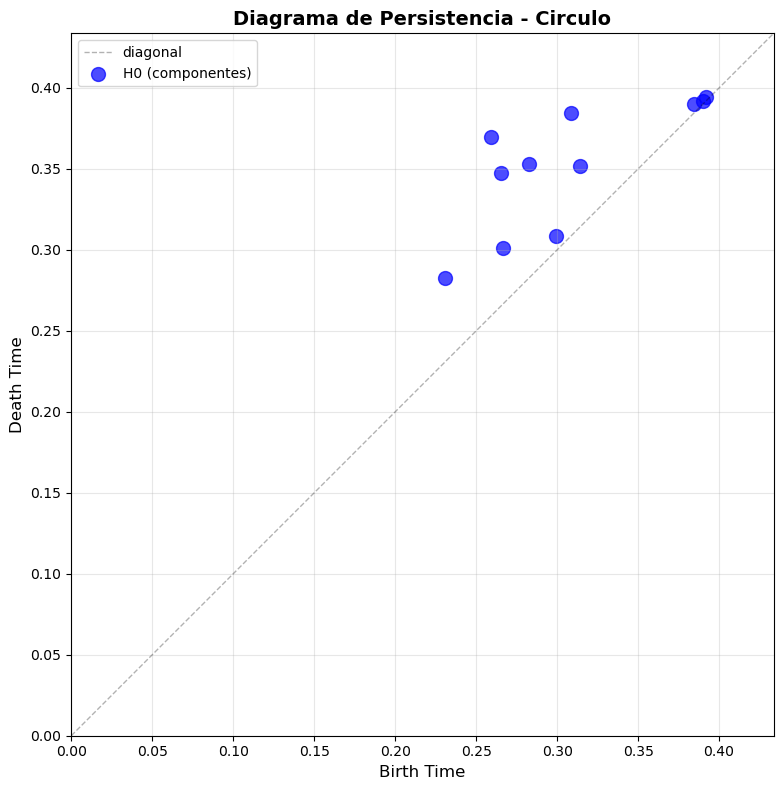

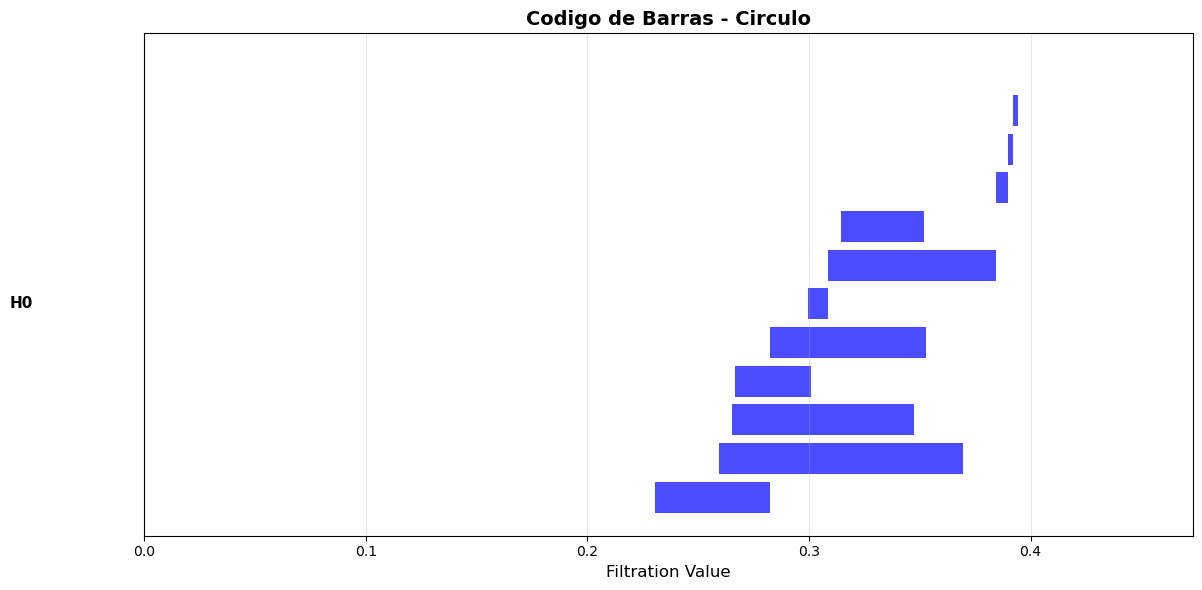


--- PRUEBA 2: Aproximacion de una linea ---
H0 (componentes): 9 puntos
H1 (agujeros): 0 puntos


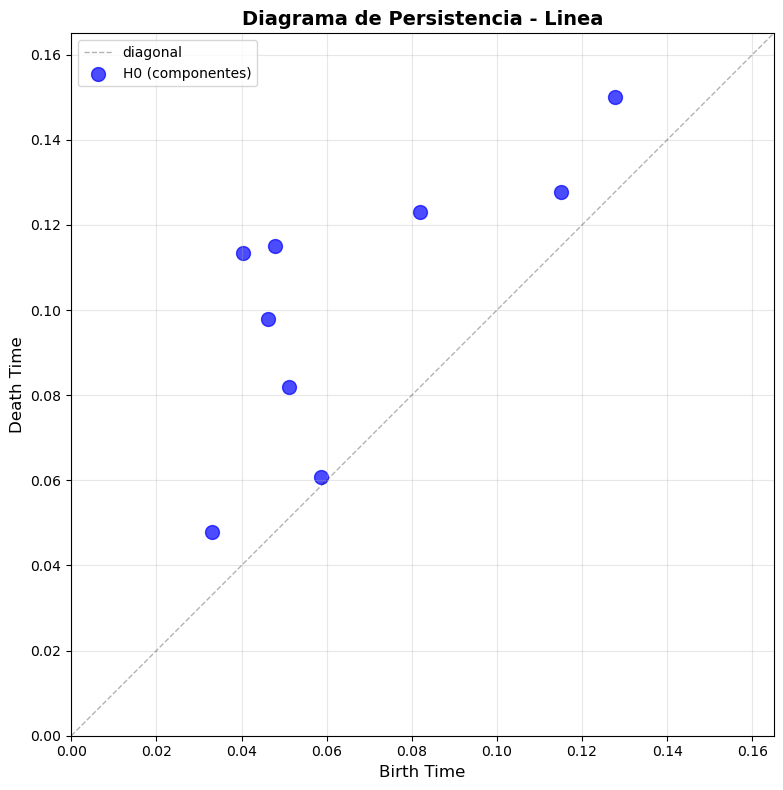

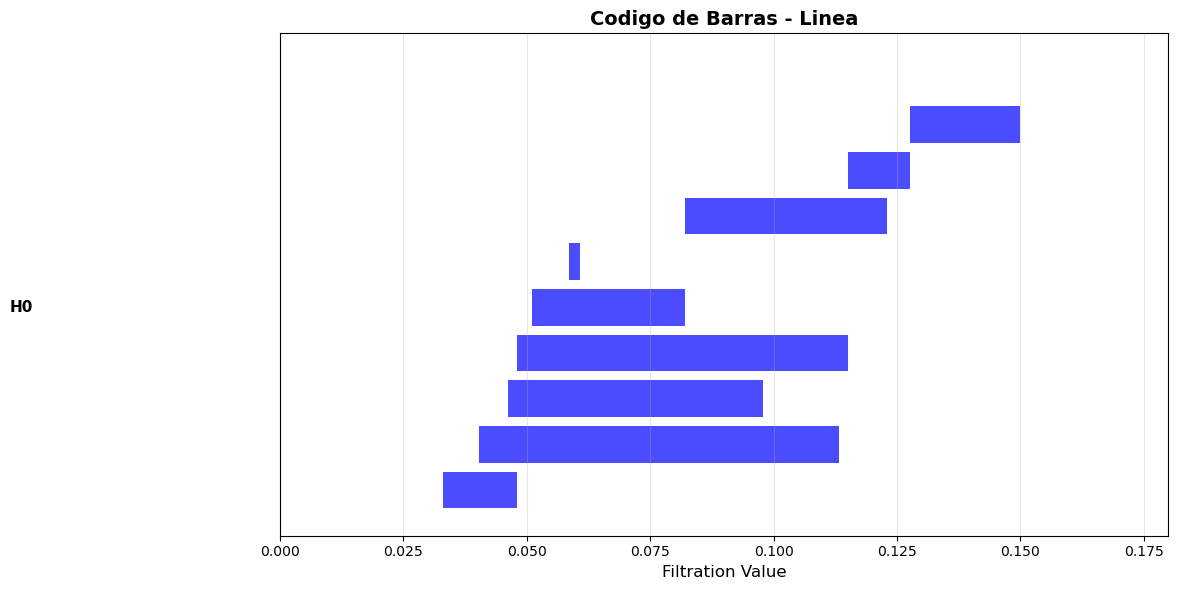


--- PRUEBA 3: Dos componentes conexas separadas ---
H0 (componentes): 12 puntos
H1 (agujeros): 0 puntos


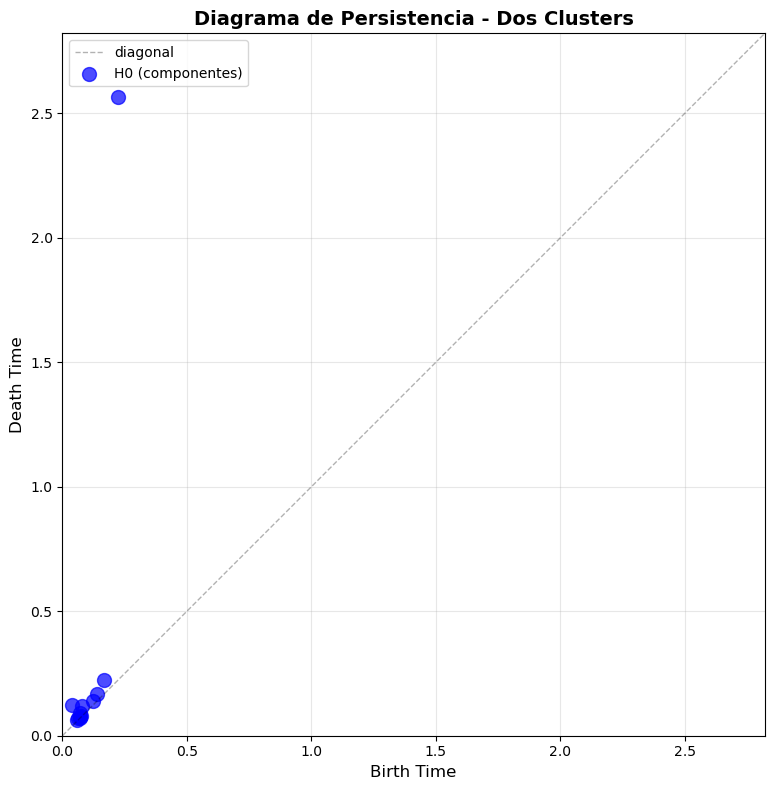

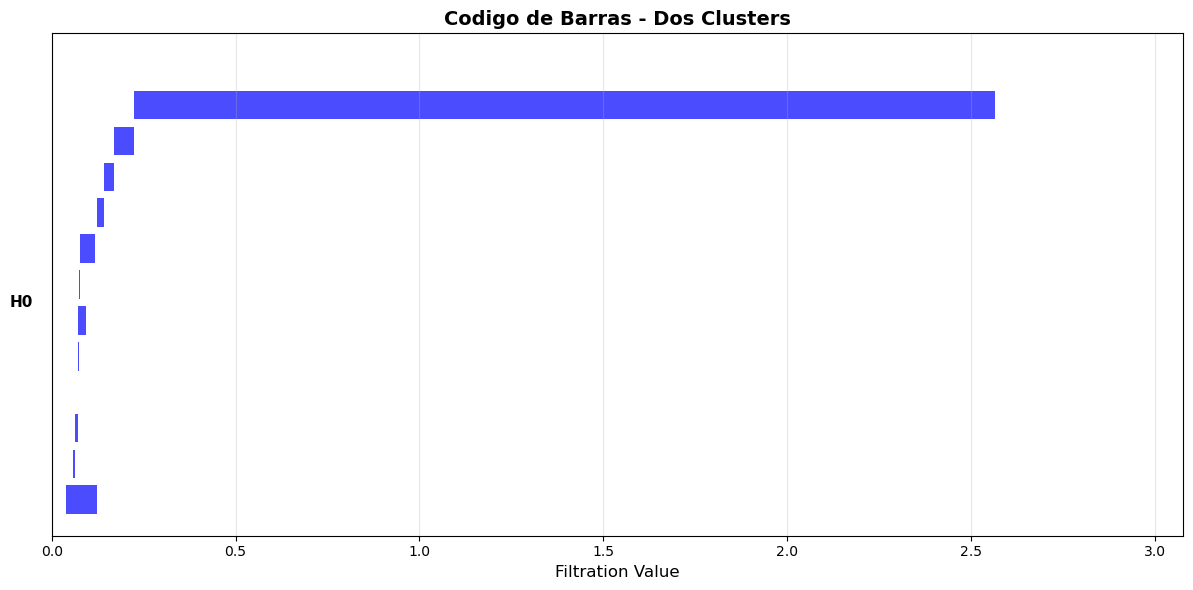


=== FIN DE LAS PRUEBAS ===


In [19]:
# BLOQUE 5.4: PRUEBAS DE LAS FUNCIONES
# Testear las funciones con diferentes conjuntos de puntos

print("\n=== PRUEBAS DE EJERCICIOS PARA PROGRAMAR ===")
print("\nLas siguientes funciones han sido implementadas:")
print("1. persistence_diagram_alpha() - Calcula el diagrama de persistencia")
print("2. plot_persistence_diagram() - Dibuja el diagrama de persistencia")
print("3. plot_barcode() - Dibuja el código de barras")

# Prueba 1: Círculo (debería mostrar B1=1 con persistencia alta)
print("\n--- PRUEBA 1: Aproximación de un círculo ---")
np.random.seed(42)
theta = np.linspace(0, 2*np.pi, 20, endpoint=False)
circle_points = np.column_stack([np.cos(theta), np.sin(theta)])
# Agregar ruido pequeño
circle_points += np.random.normal(0, 0.05, circle_points.shape)

circle_diagram = persistence_diagram_alpha(circle_points)
print(f"H0 (componentes): {len(circle_diagram['H0'])} puntos")
print(f"H1 (agujeros): {len(circle_diagram['H1'])} puntos")
plot_persistence_diagram(circle_diagram, 'Diagrama de Persistencia - Circulo')
plot_barcode(circle_diagram, 'Codigo de Barras - Circulo')

# Prueba 2: Línea (debería mostrar solo B0, sin agujeros)
print("\n--- PRUEBA 2: Aproximacion de una linea ---")
line_points = np.column_stack([np.linspace(0, 1, 15), np.zeros(15)])
line_points += np.random.normal(0, 0.03, line_points.shape)

line_diagram = persistence_diagram_alpha(line_points)
print(f"H0 (componentes): {len(line_diagram['H0'])} puntos")
print(f"H1 (agujeros): {len(line_diagram['H1'])} puntos")
plot_persistence_diagram(line_diagram, 'Diagrama de Persistencia - Linea')
plot_barcode(line_diagram, 'Codigo de Barras - Linea')

# Prueba 3: Dos componentes separadas
print("\n--- PRUEBA 3: Dos componentes conexas separadas ---")
cluster1 = np.random.normal([0, 0], 0.1, (8, 2))
cluster2 = np.random.normal([2, 2], 0.1, (8, 2))
two_clusters = np.vstack([cluster1, cluster2])

clusters_diagram = persistence_diagram_alpha(two_clusters)
print(f"H0 (componentes): {len(clusters_diagram['H0'])} puntos")
print(f"H1 (agujeros): {len(clusters_diagram['H1'])} puntos")
plot_persistence_diagram(clusters_diagram, 'Diagrama de Persistencia - Dos Clusters')
plot_barcode(clusters_diagram, 'Codigo de Barras - Dos Clusters')

print("\n=== FIN DE LAS PRUEBAS ===")
